### Importing Libraries

In [149]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import numpy as np
from statsmodels.graphics.mosaicplot import mosaic
pd.set_option('display.max_columns', None)

### Reading the data

In [150]:
rec = pd.read_csv('CleanRecruitment.csv')
ros = pd.read_csv('cleaned_roster.csv')

### Re-cleaning the data

In [151]:
ros.drop(columns='Unnamed: 0', inplace = True)

ros['Fluent Language(s)'] = ros['Fluent Language(s)'].apply(lambda x: int(x[0]))

for col in ros.columns.tolist():
    if '-Fluent' in col:
        ros[col] = ros[col].apply(lambda x: 1 if x == "Y" else 0)

rec['Job Code'] = rec['Job Code'].apply(lambda x: int(x[4:]))


### Creating useful dataframes

In [152]:
# Here, we join recruitment and roster dataframes. 

# This is the new merge. It merges right with left. Basiclly including all that has been recuited
Hired = ros.drop_duplicates().merge(rec, on=['Applicant Number'], how='right', indicator=True)

# "Hired" dataframe contains the same person multiple times, the reason being is that -
#  - a person could get hired, after that, they could get promoted or demoted.
# Proven by this line.

# We change the data type from "Object" to "datetime". Such that, they're easier to use. 
Hired['SelectionMonth'] = pd.to_datetime(Hired['SelectionMonth'])
Hired['PostingMonth'] = pd.to_datetime(Hired['PostingMonth'])

Hired.drop(columns=['Job Code_x', 'Job Family_x', 'JO Type_x',  'Posting Year', 'Gender_x', 'Nationality_x',
                    'JO Number',  'Nationality Region', 'RosterDate', 'Roster Year', 'Entity', 'Nationality_y'], inplace = True)

recRoster = rec.loc[(rec['JO Selection'] == 'Roster')]
recNonRosterButHeIsThere = rec.loc[(rec['JO Selection'] == 'Non-roster') & (rec['Candidate Rostered?'] == 'Yes')]
HiredNonRos = rec.loc[(rec['JO Selection'] == 'Non-roster') & (rec['Candidate Rostered?'] == 'No')]


HiredRos = ros.merge(recRoster, on=['Applicant Number'], how='right', indicator=True)
HiredNonRosterButHeIsThere = ros.merge(recNonRosterButHeIsThere, on=['Applicant Number', 'Gender', 'Nationality'], how='right', indicator=True)

HiredRosAll = pd.concat([HiredRos, HiredNonRosterButHeIsThere])

### Visualization the data

Text(0.5, 1.0, 'Age to Level employment rate')

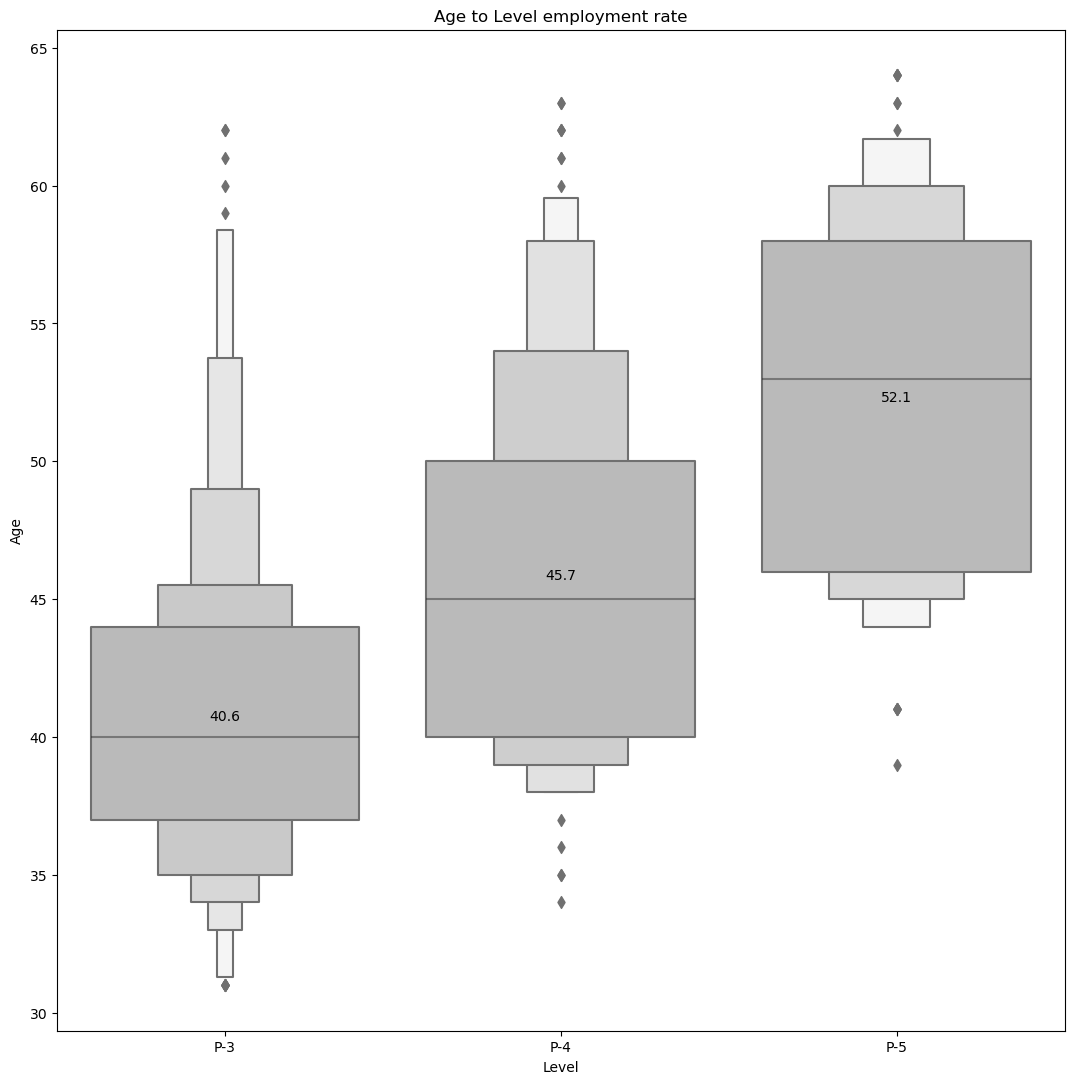

In [153]:
plt.subplots(figsize=(13, 13))

levels = (HiredRosAll.groupby(['Level', 'Age'])['Age'].count())

plot = sns.boxenplot(data = HiredRosAll, x = 'Level', y = 'Age', palette = ['#BABABA'])

levels= ['P-3', 'P-4', 'P-5']
for i, level in enumerate(levels):
    y = (HiredRosAll[HiredRosAll['Level'] == levels[i]]['Age']).mean()
    plot.annotate(str(y)[:4], (i,  y), ha='center')

plt.title('Age to Level employment rate')

Text(0, 0.5, 'Number of Employees')

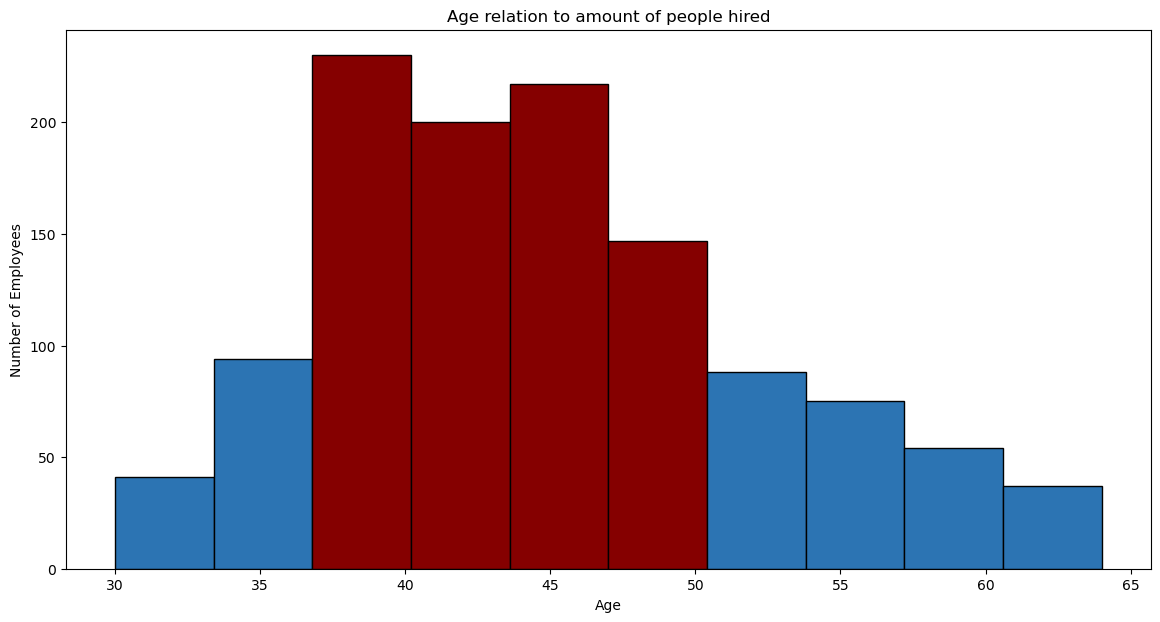

In [154]:
plt.figure(figsize=(14,7))

# From this figure, we can notice that most recruited people are people between the ages of 37 - 50

plot = sns.histplot(Hired['Age'], bins = 10)

for i in range(10):
    if i in [2,3,4,5]:
        plot.patches[i].set_facecolor('#850000')
    else:
        plot.patches[i].set_facecolor('#2C74B3')
plt.title("Age relation to amount of people hired")
plt.xlabel('Age')
plt.ylabel('Number of Employees')


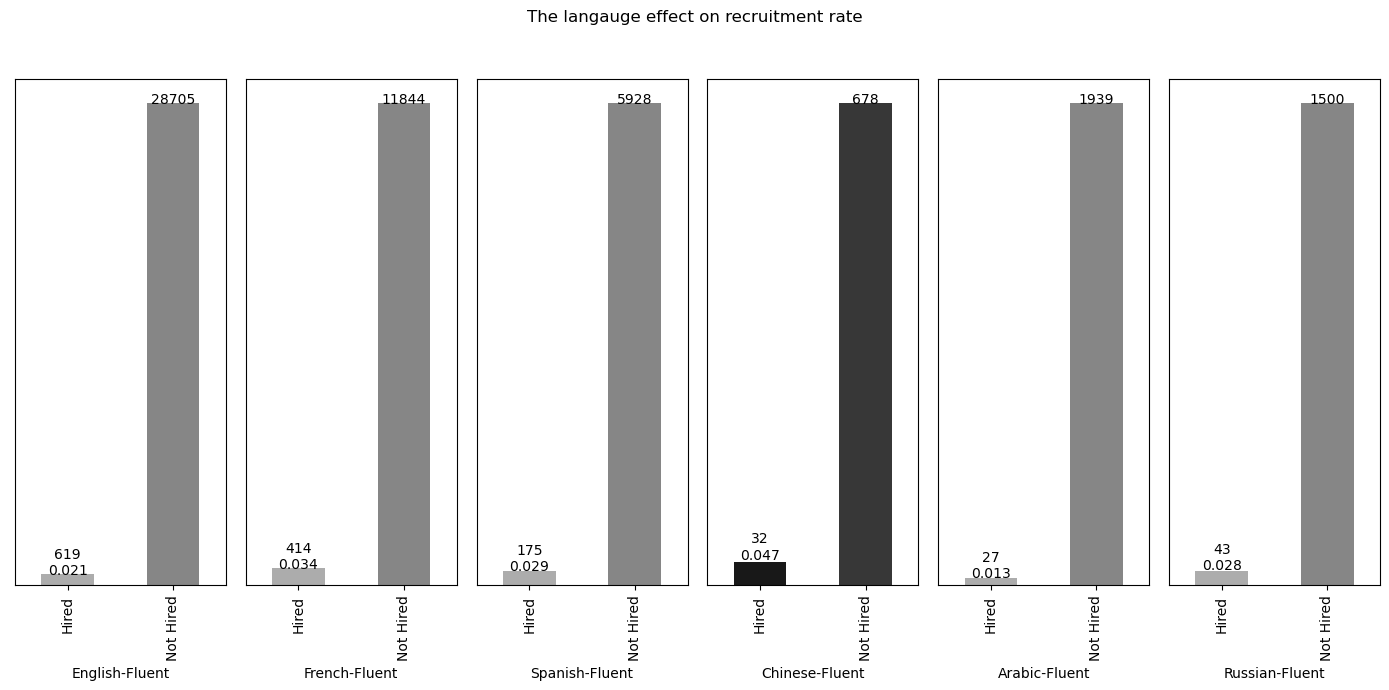

In [155]:
langs = ['English-Fluent', 'French-Fluent', 'Spanish-Fluent', 'Chinese-Fluent', 'Arabic-Fluent', 'Russian-Fluent', 'Applicant Number']

cc = HiredRosAll[langs].copy()
cc['Hired?'] = 'Hired'

fluency = pd.concat([ros[langs], cc])
fluency['Hired?'] = fluency['Hired?'].fillna('Not Hired')

figure, axis = plt.subplots(nrows=1, ncols=6, figsize=(14,7))

alangs =  ['English-Fluent', 'French-Fluent', 'Spanish-Fluent', 'Chinese-Fluent', 'Arabic-Fluent', 'Russian-Fluent']

for num, i in enumerate(alangs):
    if i == 'Chinese-Fluent':
        axis[num].set_yticks([], [])
        temp = fluency.groupby([i, 'Hired?'])[i].count()[1]
        temp.plot(kind='bar',ax=axis[num], color = ['#181818', '#373737'])
        axis[num].set_xlabel(i)
        axis[num].annotate(temp['Not Hired'], (1, temp['Not Hired']), ha='center')
        axis[num].annotate(str(temp['Hired']) + '\n' + str(temp['Hired']/(temp['Not Hired']))[:5], (0, temp['Hired']+5), ha='center')
        
    else:
        axis[num].set_yticks([], [])
        temp = fluency.groupby([i, 'Hired?'])[i].count()[1]
        temp.plot(kind='bar',ax=axis[num], color = ['#ACACAC', '#868686'])
        axis[num].set_xlabel(i)
        axis[num].annotate(temp['Not Hired'], (1, temp['Not Hired']), ha='center')
        axis[num].annotate(str(temp['Hired']) + '\n' + str(temp['Hired']/(temp['Not Hired']))[:5], (0, temp['Hired']+5), ha='center')
        
figure.tight_layout()
figure.suptitle('The langauge effect on recruitment rate')

figure.subplots_adjust(top=0.88)

Text(0.5, 1.0, 'Entity Type in relativity to age between genders')

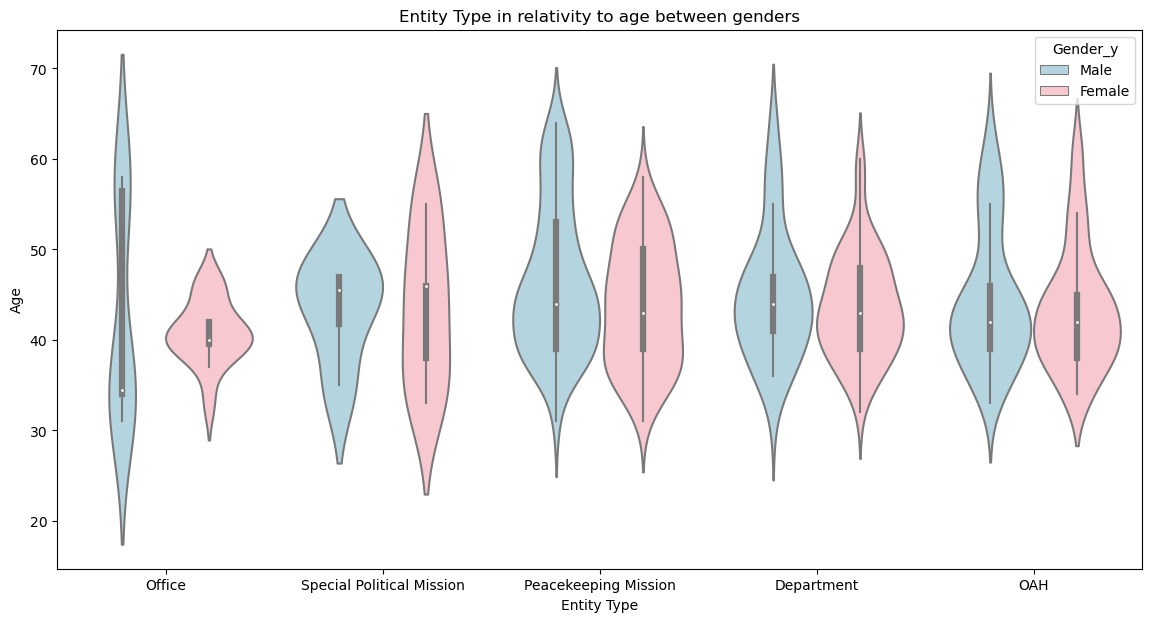

In [156]:
plt.figure(figsize=(14,7))

# Though this graph originally was created to check if gender effects where a person works, it accidently showed us that most hired females are younger than males (Will be confirmed or denied in the next cell). And the first assumption was wrong (being that gender effects which entity type you work in).  

sns.violinplot(data = HiredRosAll,x = 'Entity Type',  y = 'Age', hue = 'Gender_y', order = ['Office', 'Special Political Mission', 'Peacekeeping Mission', 'Department', 'OAH'], palette=['lightblue', 'pink'])

plt.title('Entity Type in relativity to age between genders')

C:\Users\maryam osama\AppData\Local\Temp\ipykernel_14468\565118213.py:8: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  Q25Age = HiredRosAll.groupby('Gender_y').quantile(0.25)['Age']
C:\Users\maryam osama\AppData\Local\Temp\ipykernel_14468\565118213.py:9: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  Q75Age = HiredRosAll.groupby('Gender_y').quantile(0.75)['Age']


Text(0.5, 1.0, 'Is there any correlation between age and gender?')

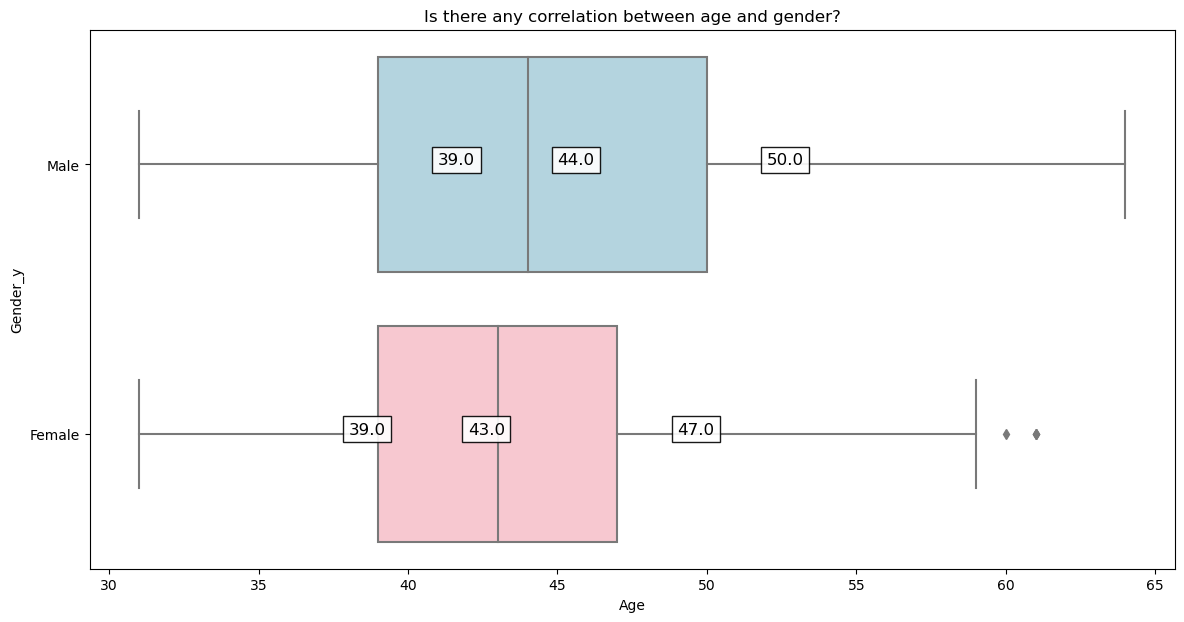

In [157]:
plt.figure(figsize=(14,7))

# Here, we prove that the assumption we had in the above cell was indeed correct.

sns.boxplot(data = HiredRosAll, y='Gender_y', x  ='Age', palette=['lightblue', 'pink'])

medianAge = HiredRosAll.groupby('Gender_y').median()['Age']
Q25Age = HiredRosAll.groupby('Gender_y').quantile(0.25)['Age']
Q75Age = HiredRosAll.groupby('Gender_y').quantile(0.75)['Age']


plt.text(38, 1, Q25Age[0],
         bbox=dict(facecolor='white',
                   alpha=0.9),
         fontsize=12)
plt.text(42, 1, medianAge[0],
         bbox=dict(facecolor='white',
                   alpha=0.9),
         fontsize=12)
plt.text(49, 1, Q75Age[0],
         bbox=dict(facecolor='white',
                   alpha=0.9),
         fontsize=12)


plt.text(41, 0, Q25Age[1],
         bbox=dict(facecolor='white',
                   alpha=0.9),
         fontsize=12)
plt.text(45, 0, medianAge[1],
         bbox=dict(facecolor='white',
                   alpha=0.9),
         fontsize=12)
plt.text(52, 0, Q75Age[1],
         bbox=dict(facecolor='white',
                   alpha=0.9),
         fontsize=12)

plt.title('Is there any correlation between age and gender?')

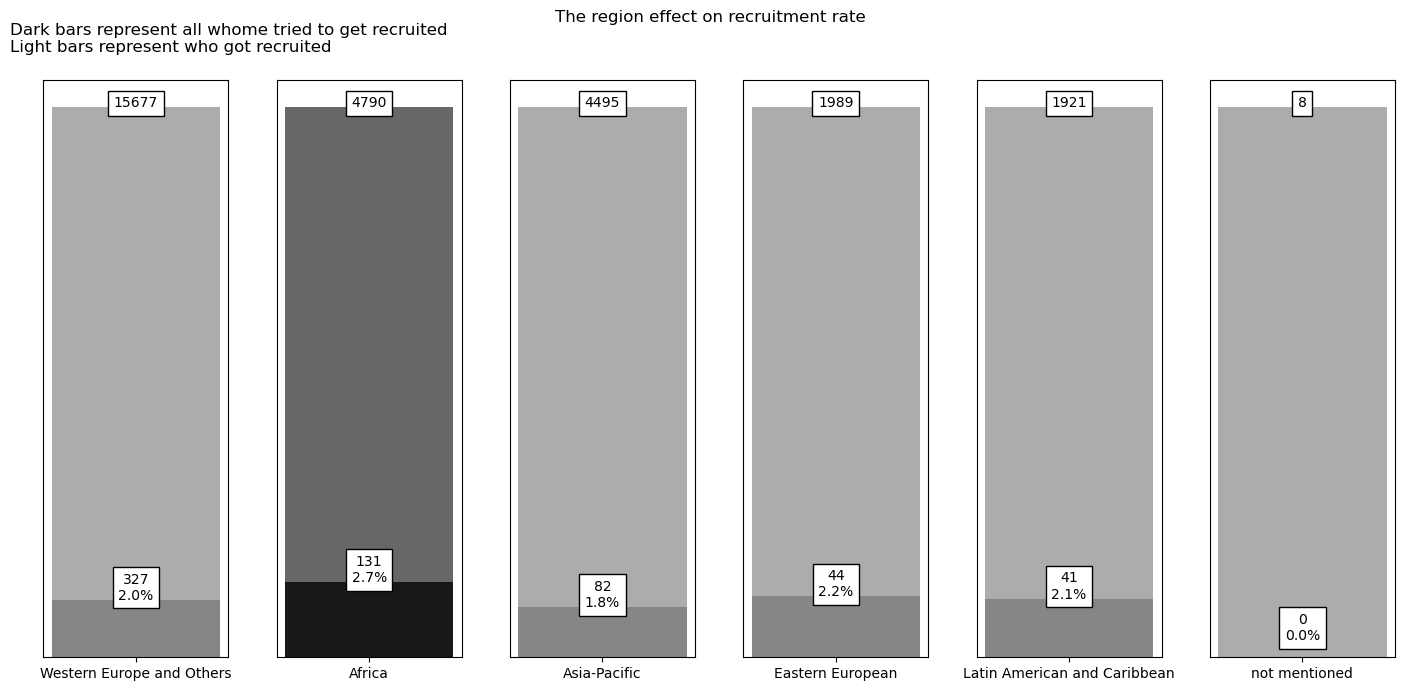

In [158]:
figure, axis = plt.subplots(nrows=1, ncols=6, figsize=(14,7))

regCount = rec['Region'].value_counts()
regCount['Not mentioned'] = 0
regrosCount = ros['Nationality Region'].value_counts()
regrosCount = regrosCount.rename({'African' : 'Africa', 'not mentioned' : 'Not mentioned'})

for num, i in enumerate(['Western Europe and Others', 'Africa', 'Asia-Pacific', 'Eastern European', 'Latin American and Caribbean', 'not mentioned']):
    axis[num].set_yticks([], [])
    if i == 'Africa':
        axis[num].bar(x = i, height= (regrosCount[num]/5), color = '#676767')
        axis[num].bar(x = i, height= (regCount[num]), color = '#181818')

    else:
        axis[num].bar(x = i, height= (regrosCount[num]/5), color = '#ACACAC')
        axis[num].bar(x = i, height= (regCount[num]), color = '#868686')

    text = str(regCount[num]) + '\n' +str(regCount[num]*10 / regrosCount[num]*10)[:3] + '%'
    axis[num].annotate(str(regrosCount[num]), (0, regrosCount[num]/5), ha='center', bbox=dict(facecolor='white'))
    axis[num].annotate(text, (0, regCount[num]+0.05), ha='center', bbox=dict(facecolor='white'))
    
figure.tight_layout()
figure.suptitle('The region effect on recruitment rate')
figure.text(0, 0.92, 'Dark bars represent all whome tried to get recruited\nLight bars represent who got recruited', fontsize = 12)


figure.subplots_adjust(top=0.88)



##################################

In [159]:
#does the gender effect the candidate being chosen on not
ros['Chosen'] = ros["Applicant Number"].apply(lambda x: "Yes" if x in rec["Applicant Number"].unique() else "No")

In [160]:
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
import scipy.stats as stats

contingency_table_gender = pd.crosstab(ros['Gender'], ros['Chosen'])
contingency_table_nationality = pd.crosstab(ros['Nationality Region'],ros['Chosen'])

chi2_gender, p_gender, dof_gender, expected_gender = chi2_contingency(contingency_table_gender)
chi2_nationality, p_nationality, dof_nationality, expected_nationality = chi2_contingency(contingency_table_nationality)

print("p-value for Gender: ", p_gender)
print()
print("p-value for Nationality Region: ", p_nationality)

#between Gender and being chosen the p-value is p-value is less than the significance level, we can reject the null hypothesis that there is no association
#,and conclude that there is a statistically significant association.

#between the Nationality Region and being chosen the p-value is greater than the significance level,
#we fail to reject the null hypothesis, which means we don't have enough evidence to suggest that there is an association
#, we can conclude that there is no statistically significant association.

p-value for Gender:  2.18758706462349e-05

p-value for Nationality Region:  0.3551389486544789


In [161]:

#data is normal

female = HiredRosAll[HiredRosAll['Gender_y'] == 'Female']['Age']
male = HiredRosAll[HiredRosAll['Gender_y'] == 'Male']['Age']

t_stat, p_value = ttest_ind(female, male)

print("p-value: ", p_value)

#performing t-test p-value is less than the significance level, we can reject the null hypothesis that there is no association
#and conclude that there is a statistically significant association.

p-value:  0.0016574910457862395


In [167]:
#here data doesn't show normality so using a non-paramatric test like kruskal 

lp3 = HiredRosAll[HiredRosAll['Level'] == 'P-3']['Age']
lp4 = HiredRosAll[HiredRosAll['Level'] == 'P-4']['Age']
lp5 = HiredRosAll[HiredRosAll['Level'] == 'P-5']['Age']

resul = stats.kruskal(lp3,lp4,lp5)
if resul.pvalue < 0.05 :
    print("reject null hypothesis")
else:
    print("fail to reject the null hypothesis")
    
#performing t-test p-value is less than the significance level, we can reject the null hypothesis that there is no association
#and conclude that there is a statistically significant association.

reject null hypothesis
